# Rainy River Flows

The purpose of this notebook is to create a data series for the flow on upper Rainy River. The data series is written to a file `RR.pkl` that can be read into other notebooks using `RR = pd.read_pickle('./data/RR.pkl')`.
The data series is constructed using data for station 05PC019 from the Water Survey of Canada database.

## Read Data from Water Survey of Canada

The Water Survey of Canada currently maintains level and flow stations on Rainy River River. Station 05PC019, located on Rainy River near the International Falls Dam, records flow rate on upper Rainy River.

The data set is imported into the workspace by running the Water Survey of Canada notebook.

In [1]:
# Display graphics inline with the notebook
%matplotlib notebook

# Standard Python modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
import requests

# Modules to display images and data tables
from IPython.display import Image
from IPython.core.display import display

dir = '../data/'
img = '../images/'

WSC_STATIONS = pd.read_pickle('../data/WSC_STATIONS')
WSC_LEVELS = pd.read_pickle('../data/WSC_LEVELS')
WSC_FLOWS = pd.read_pickle('../data/WSC_FLOWS')

def mapWSC(lvlList,floList=[]):
    # return a .png map image
    rSet = set(lvlList).difference(set(floList))
    gSet = set(floList).difference(set(lvlList))
    bSet = set(lvlList).intersection(set(floList))

    rMarkers = '&markers=color:red%7Csize:mid%7C' + \
        "|".join(["{0},{1}".format(WSC_STATIONS.ix[s,'LATITUDE'], \
                                   WSC_STATIONS.ix[s,'LONGITUDE']) for s in rSet]) 
    gMarkers = '&markers=color:green%7Csize:mid%7C' + \
        "|".join(["{0},{1}".format(WSC_STATIONS.ix[s,'LATITUDE'], \
                                   WSC_STATIONS.ix[s,'LONGITUDE']) for s in gSet])
    bMarkers = '&markers=color:blue%7Csize:mid%7C' + \
        "|".join(["{0},{1}".format(WSC_STATIONS.ix[s,'LATITUDE'], \
                                   WSC_STATIONS.ix[s,'LONGITUDE']) for s in bSet])
    google_maps_url = \
        "https://maps.googleapis.com/maps/api/staticmap?" + \
        "size=640x400" + \
        "&maptype=terrain" + \
        rMarkers + gMarkers + bMarkers
    return Image(requests.get(google_maps_url).content)

The following map shows the location of flow station 05PC019 relative to level stations at Pither's Point Site No. 1 (05PC024, Base of Rainer Rapids), Pither's Point Site No 2. (05PC205, downstream of the narrows), and Rainy Lake near Fort Frances (05PB007). 

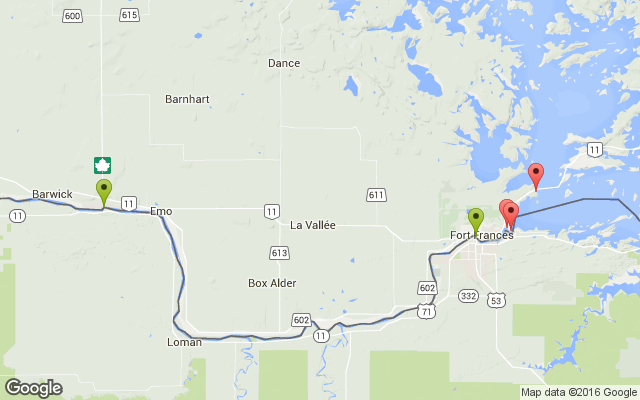

In [2]:
lvls = ['05PC024','05PC025','05PB007']
flos = ['05PC019','05PC018']

mapWSC(lvls,flos)

## Data History

,Level,Flow,STATION_NAME,LATITUDE,LONGITUDE
STATION_NUMBER,,,,,
05PC019,True,True,RAINY RIVER AT FORT FRANCES,48.60853,-93.40344
05PC018,True,True,RAINY RIVER AT MANITOU RAPIDS,48.63447,-93.91336


<IPython.core.display.Javascript object>


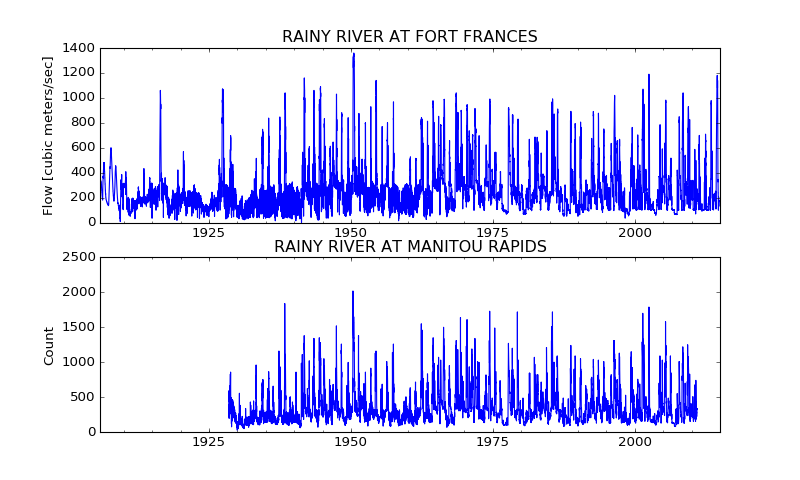

In [3]:
ff = '05PC019'
mr = '05PC018'

display(WSC_STATIONS.ix[[ff,mr]])

plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
WSC_FLOWS[ff].plot()
plt.title(WSC_STATIONS.ix[ff,'STATION_NAME'])
plt.ylabel('Flow [cubic meters/sec]');

plt.subplot(2,1,2)
WSC_FLOWS[mr].plot()
plt.title(WSC_STATIONS.ix[mr,'STATION_NAME'])
plt.ylabel('Count')

## Data Reconciliation

As a test for gross data errors, here we plot the flow on Rainy River measured at the downstream location Manitou Rapids (05PC018) versus the flow measured at Fort Frances (05PC019).  Under normal conditions, the downstream location should include the flow at Fort Frances plus possibly substantial flows entering the river between Fort Frances and Manitou Rapids.

A separate plot is constructed for each year over a range of years. The axes have been rescaled to units of 1000 cubic meters/second.

<IPython.core.display.Javascript object>


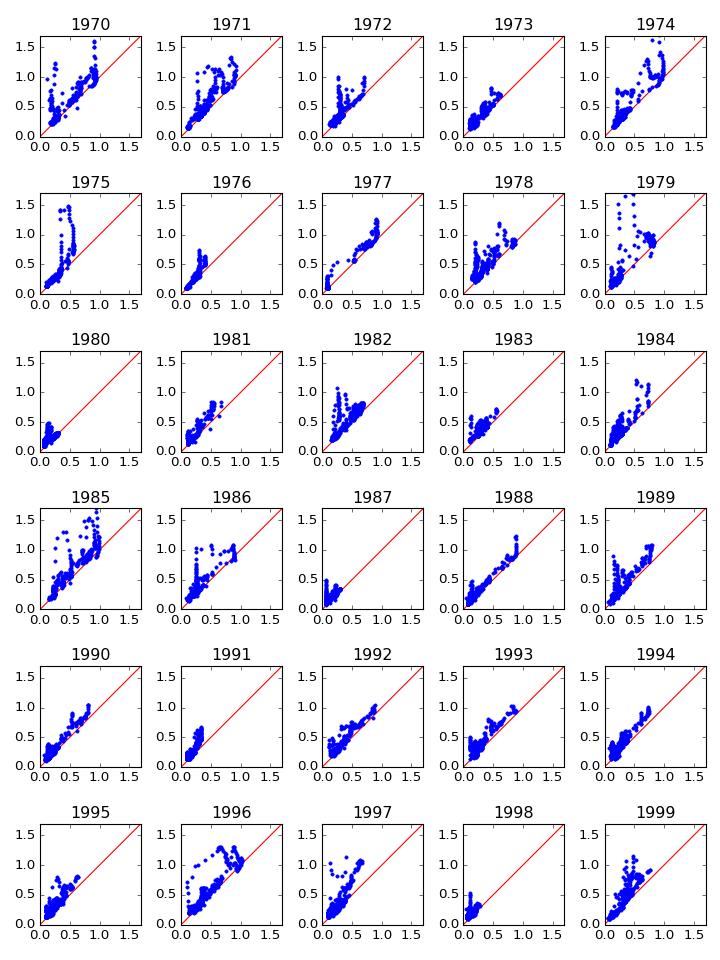

In [4]:
plt.figure(figsize=(9,12))
for k in range(0,30):
    plt.subplot(6,5,k+1)
    plt.axis('equal')
    plt.axis('square')
    plt.hold(True)

    plt.plot([0,1.700],[0,1.700],'r')
    st = datetime.datetime(1970+k,1,1)
    en = datetime.datetime(1970+k,12,31)
    F = WSC_FLOWS.ix[st:en,[ff,mr]]

    plt.plot(F[ff]/1000,F[mr]/1000,'.')
    plt.xlim(0,1.700)
    plt.ylim(0,1.700)
    plt.xticks([0.0,0.5,1.0,1.5])
    plt.yticks([0.0,0.5,1.0,1.5])
    plt.title('{0}'.format(1970+k))

    plt.hold(False)

plt.tight_layout()
plt.savefig('../images/RainyRiverXcorr.png')

## Writing Rainy River Flow Data to a file

<IPython.core.display.Javascript object>


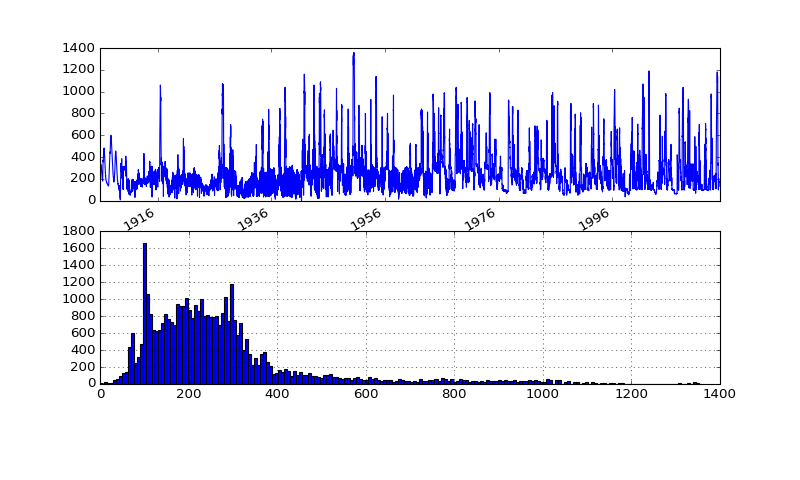

In [5]:
RR = WSC_FLOWS[ff]
RR.to_pickle('../data/RR.pkl')

RRflow = RR.dropna(how = 'any')
RRflow = pd.DataFrame(RRflow)
RRflow['datenum'] = (RRflow.index - datetime.datetime(1900,1,1)).days + 693962.0
RRflow.to_csv(dir + 'RRflow.csv')

plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
RRflow[ff].plot()
plt.subplot(2,1,2)
RRflow[ff].hist(bins=200)

## Recalibration

Recently, Jean Morin (2016) has proposed a specific recalibration of the 

<IPython.core.display.Javascript object>


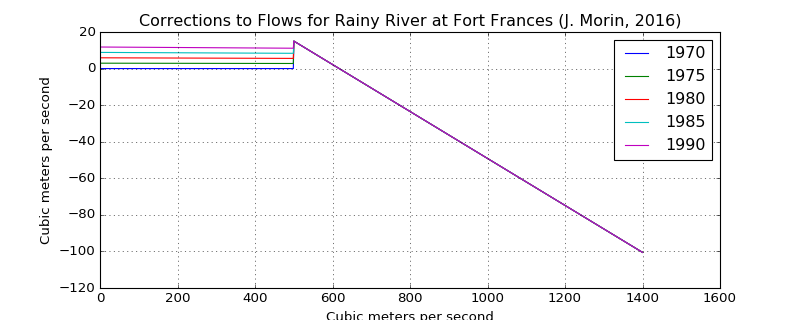

In [6]:
def reflo(q,yr):
    if q <= 500.0:
        # low flow case
        if yr < 1970:
            return q
        elif yr >= 1990:
            return 0.99868*q + 11.78713
        else:
            alpha = (yr-1970)/20.0
            return (0.99868*q + 11.78713)*alpha + q*(1-alpha)
    else:
        # high flow case
        return 0.87157*q + 79.28214

# plot correction
plt.figure(figsize=(10,4))
qplot = np.linspace(0,1400,1000)
years = range(1970,1995,5)
plt.hold(True)
for yr in years:
    plt.plot(qplot,[reflo(q,yr)-q for q in qplot])

plt.xlim(0,1600)
plt.legend(['{0}'.format(yr) for yr in years])
plt.title('Corrections to Flows for Rainy River at Fort Frances (J. Morin, 2016)')
plt.ylabel('Cubic meters per second')
plt.xlabel('Cubic meters per second')
plt.grid()

plt.savefig(img + 'RainyRiverCorrections_Morin')

<IPython.core.display.Javascript object>


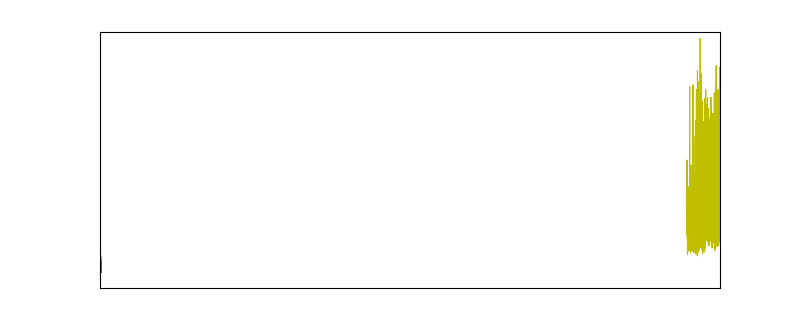

In [12]:
def reflo(q,yr):
    if yr < 1970:
        deltaQ_lo = 0.0
    elif yr >= 1990:
        deltaQ_lo = 0.99868*q + 11.78713 - q
    else:
        alpha = (yr-1970)/20.0
        deltaQ_lo = (0.99868*q + 11.78713)*alpha + q*(1-alpha) - q
    deltaQ_hi =  0.87157*q + 79.28214 - q
    return q + min(deltaQ_lo,deltaQ_hi)

# plot correction
plt.figure(figsize=(10,4))
qplot = np.linspace(0,1400,1000)
years = range(1970,1995,5)
plt.hold(True)
for yr in years:
    plt.plot(qplot,[reflo(q,yr)-q for q in qplot])

plt.xlim(0,1600)
plt.legend(['{0}'.format(yr) for yr in years])
plt.title('Regularized Corrections to Flows for Rainy River at Fort Frances (J. Morin, 2016)')
plt.ylabel('Cubic meters per second')
plt.xlabel('Cubic meters per second')
plt.grid()

plt.savefig(img + 'RainyRiverCorrections')

In [7]:
RR_corrected = pd.Series([reflo(val,idx.year) for (idx,val) in RR.iteritems()], index = RR.index)
RR_corrected.to_pickle('../data/RR_corrected.pkl')

<IPython.core.display.Javascript object>


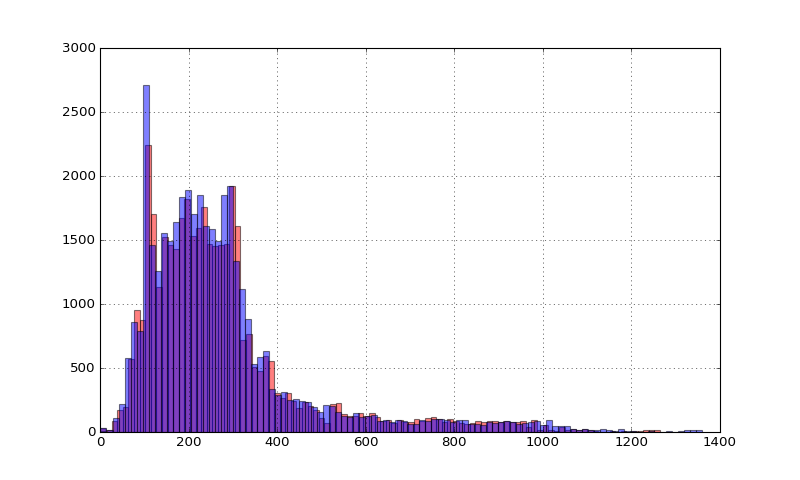

In [8]:
plt.figure(figsize=(10,6))
RR_corrected.hist(bins=100,color='red',alpha=0.5)
RR.hist(bins=100,color='blue',alpha=0.5)
